In [1]:
import os
import re

import numpy as np
import pandas as pd
import tables

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, r2_score, mean_absolute_error

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, accuracy
from surprise import KNNBasic

In [3]:
from gensim.models import FastText

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model

2023-04-30 23:05:20.561838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading data and data preprocessing

In [4]:
taste_profile_df = pd.read_csv('/home/016709732/dataset/train_triplets.txt', sep='\t', header=None, names = ['user_id','song_id','play_count'], nrows = 2000000)
taste_profile_df.shape

(2000000, 3)

In [5]:
taste_profile_df.head(8)

user_id             song_id  play_count
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9           1
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B           2
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22           1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFOVM12A58A7D494           1
5  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBNZDC12A6D4FC103           1
6  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBSUJE12A6D4F8CF5           2
7  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBVFZR12A6D4F8AE3           1

In [6]:
taste_profile_df.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

In [7]:
taste_profile_df.duplicated().sum()

0

In [8]:
song_data_df = tables.open_file("/home/016709732/dataset/msd_summary_file.h5", mode="r")
song_data_table = song_data_df.root.metadata.songs
metadata_table_df = pd.DataFrame.from_records(song_data_table[:])
metadata_table_df.shape

(1000000, 20)

In [9]:
metadata_table_df.drop(columns =['analyzer_version', 'artist_7digitalid','artist_id', 'idx_artist_terms','idx_similar_artists','release_7digitalid','artist_location','artist_longitude','artist_latitude','artist_playmeid','track_7digitalid','artist_mbid'],inplace=True)
metadata_table_df.replace({b'': np.nan}, inplace=True)
print(metadata_table_df.isna().sum())
metadata_table_df.drop(columns =['genre'],inplace=True)

artist_familiarity        185
artist_hotttnesss          12
artist_name                 0
genre                 1000000
release                     0
song_hotttnesss        418035
song_id                     0
title                      15
dtype: int64


In [10]:
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.head(8)

artist_familiarity  artist_hotttnesss         artist_name  \
0            0.649822           0.394032    Faster Pussy cat   
1            0.439604           0.356992    Karkkiautomaatti   
2            0.643681           0.437504      Hudson Mohawke   
3            0.448501           0.372349         Yerba Brava   
4            0.000000           0.000000          Der Mystic   
5            0.361287           0.109626    David Montgomery   
6            0.692923           0.453732  Sasha / Turbulence   
7            0.588156           0.401092          Kris Kross   

                                release  song_hotttnesss             song_id  \
0                 Monster Ballads X-Mas         0.542899  SOQMMHC12AB0180CB8   
1                           Karkuteillä         0.299877  SOVFVAK12A8C1350D9   
2                                Butter         0.617871  SOGTUKN12AB017F4F1   
3                               De Culo              NaN  SOBNYVR12A8C13558C   
4  Rene Ablaze Presents Winter Sessions              NaN  SOHSBXH12A8C13B0DF   
5      Berwald: Symphonies Nos. 1/2/3/4              NaN  SOZVAPQ12A8C13B63C   
6             Strictly The Best Vol. 34              NaN  SOQVRHI12A6D4FB2D7   
7                               Da Bomb              NaN  SOEYRFT12AB018936C   

                                               title  
0                                       Silent Night  
1                                        Tanssi vaan  
2                                  No One Could Ever  
3                                      Si Vos Querés  
4                                   Tangle Of Aspens  
5  Symphony No. 1 G minor "Sinfonie Serieuse"/All...  
6                                   We Have Got Love  
7                                  2 Da Beat Ch'yall

In [11]:
track_metadata = pd.read_csv('/home/016709732/dataset/track_metadata.csv')
track_metadata.shape

(1000000, 14)

In [12]:
track_metadata.drop(columns =['track_id', 'title','release', 'artist_id','artist_mbid','artist_name','artist_familiarity','artist_hotttnesss','year', 'track_7digitalid','shs_perf','shs_work'], inplace=True)

In [13]:
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration > 480].index)
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration < 60].index)

In [14]:
track_metadata.drop_duplicates(inplace=True)
track_metadata.shape

(942370, 2)

In [15]:
track_metadata.head(8)

song_id   duration
0  SOQMMHC12AB0180CB8  252.05506
1  SOVFVAK12A8C1350D9  156.55138
2  SOGTUKN12AB017F4F1  138.97098
3  SOBNYVR12A8C13558C  145.05751
6  SOQVRHI12A6D4FB2D7  212.37506
7  SOEYRFT12AB018936C  221.20444
8  SOPMIYT12A6D4F851E  139.17995
9  SOJCFMH12A8C13B0C2  104.48934

In [16]:
track_merge = pd.merge(track_metadata, taste_profile_df, on='song_id', how="right")
song_data = pd.merge(metadata_table_df, track_merge, on='song_id', how="right")
song_data.shape

(2128559, 10)

In [17]:
song_data = song_data.dropna()
song_data.drop_duplicates(inplace=True)
song_data.shape

(1776948, 10)

In [18]:
print("Columns and the datatypes in the data: \n", song_data.dtypes)
print("\n\nSummary of column statistics: \n", song_data.describe())

Columns and the datatypes in the data: 
 artist_familiarity    float64
artist_hotttnesss     float64
artist_name            object
release                object
song_hotttnesss       float64
song_id                object
title                  object
duration              float64
user_id                object
play_count              int64
dtype: object


Summary of column statistics: 
        artist_familiarity  artist_hotttnesss  song_hotttnesss      duration  \
count        1.776948e+06       1.776948e+06     1.776948e+06  1.776948e+06   
mean         7.422984e-01       5.570766e-01     6.906530e-01  2.393463e+02   
std          1.247892e-01       1.398934e-01     1.953554e-01  6.601397e+01   
min          0.000000e+00       0.000000e+00     0.000000e+00  6.002893e+01   
25%          6.639805e-01       4.646150e-01     5.911614e-01  1.990526e+02   
50%          7.653570e-01       5.400078e-01     7.146505e-01  2.320975e+02   
75%          8.384095e-01       6.118629e-01     8.222856e

In [19]:
def remove_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    df = df[(df[column_name] >= lower) & (df[column_name] <= upper)]
    return df

song_data = remove_outliers(song_data, 'play_count')
song_data = remove_outliers(song_data, 'artist_familiarity')
song_data = remove_outliers(song_data, 'artist_hotttnesss')
song_data = remove_outliers(song_data, 'song_hotttnesss')
song_data = remove_outliers(song_data, 'duration')
song_data.shape

(1428056, 10)

In [20]:
song_data = song_data.reset_index(drop=True)
song_data.head(5)

artist_familiarity  artist_hotttnesss    artist_name  \
0            0.832012           0.677482   Jack Johnson   
1            0.580555           0.482492  Billy Preston   
2            0.633119           0.417718  Paco De Lucia   
3            0.650281           0.451749   The Dead 60s   
4            0.576127           0.436974          Amset   

                                             release  song_hotttnesss  \
0                                 Thicker Than Water         0.649006   
1                                         To Die For         0.826375   
2                                Flamenco Para Niños         0.735295   
3  Nick & Norah's Infinite Playlist - Original Mo...         0.754628   
4                                              Amset         0.454193   

              song_id                            title   duration  \
0  SOAKIMP12A8C130995                         The Cove  112.63955   
1  SOAPDEY12A81C210A9             Nothing from Nothing  153.59955   
2  SOBBMDR12A8C13253B                  Entre Dos Aguas  358.24281   
3  SOBFOVM12A58A7D494  Riot Radio (Soundtrack Version)  141.42649   
4  SOBNZDC12A6D4FC103                  Sin límites (I)  190.53669   

                                    user_id  play_count  
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e           1  
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e           1  
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e           2  
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e           1  
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e           1

## EDA

In [21]:
print("Total number of unique artists: ", len(song_data['artist_name'].unique()))
print("Total number of unique releases/album names: ", len(song_data['release'].unique()))
print("Total number of unique song titles: ", len(song_data['title'].unique()))
print("Total number of unique songs: ", len(song_data['song_id'].unique()))
print("Total number of unique users: ", len(song_data['user_id'].unique()))

Total number of unique artists:  20089
Total number of unique releases/album names:  40216
Total number of unique song titles:  109224
Total number of unique songs:  127854
Total number of unique users:  41691


In [22]:
print("Top 20 active songs from taste profile subset: ")
top_songs = taste_profile_df.groupby(['song_id'])['play_count'].sum().sort_values(ascending=False)[:20]
print(top_songs)

print("\n\nTop 20 active users from taste profile subset: ")
top_users =taste_profile_df.groupby(['user_id'])['play_count'].sum().sort_values(ascending=False)[:20]
print(top_users)

Top 20 active songs from taste profile subset: 
song_id
SOBONKR12A58A7A7E0    28975
SOAUWYT12A81C206F1    25445
SOSXLTC12AF72A7F54    22045
SOEGIYH12A6D4FC0E3    16832
SOFRQTD12A81C233C0    16314
SOAXGDH12A8C13F8A1    14418
SONYKOW12AB01849C9    11818
SOPUCYA12A8C13A694    11294
SOUFTBI12AB0183F65    10866
SOVDSJC12A58A7A271    10384
SOOFYTN12A6D4F9B35     9849
SOHTKMO12AB01843B0     9769
SOBOUPA12A6D4F81F1     8980
SODJWHY12A8C142CCE     8319
SOLFXKT12AB017E3E0     7865
SOFLJQZ12A6D4FADA6     7639
SOTCMDJ12A6D4F8528     7225
SOTWNDJ12A8C143984     6938
SOUVTSM12AC468F6A7     6687
SOWCKVR12A8C142411     5922
Name: play_count, dtype: int64


Top 20 active users from taste profile subset: 
user_id
6d625c6557df84b60d90426c0116138b617b9449    5620
d9e5124935aebeb6b9b169df2d28e1fc658d3566    3794
6ccd111af9b4baa497aacd6d1863cbf5a141acc6    3527
1aa4fd215aadb160965110ed8a829745cde319eb    3282
283882c3d18ff2ad0e17124002ec02b847d06e9a    3055
2231cb435771a1a621ec44e95cdd28b81fad3288    2966
9

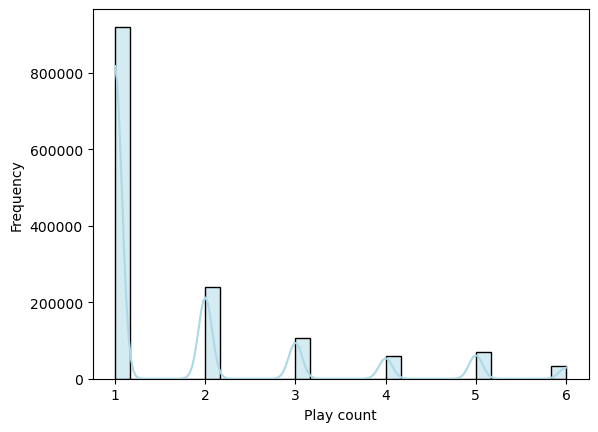

In [23]:
fig, axs = figsize=(8, 8)
sns.histplot(song_data['play_count'], kde=True, 
             bins=int(30), color = 'lightblue', 
             edgecolor='black',
             linewidth=1)
plt.xlabel('Play count')
plt.ylabel('Frequency')
plt.show()

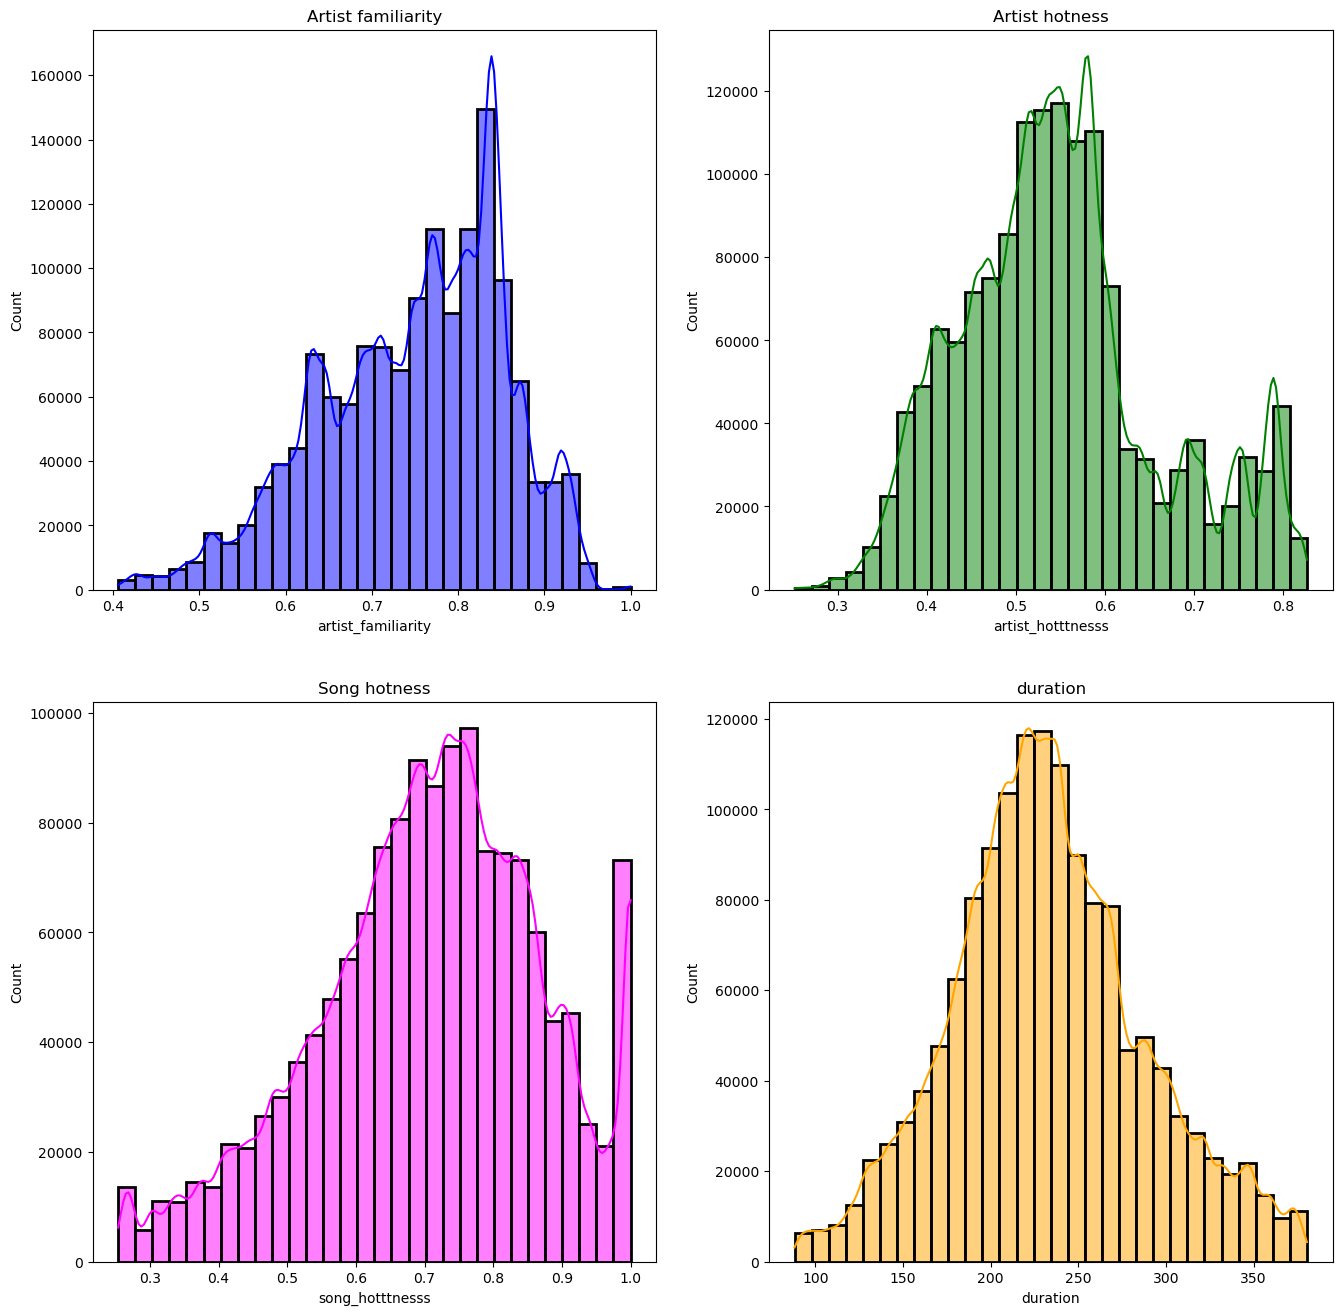

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

sns.histplot(song_data['artist_familiarity'], kde=True, 
             bins=int(30), color = 'blue', 
             edgecolor='black',
             linewidth=2, ax=axs[0][0])
axs[0][0].set_title('Artist familiarity')

sns.histplot(song_data['artist_hotttnesss'], kde=True, 
             bins=int(30), color = 'green', 
             edgecolor='black',
             linewidth=2, ax=axs[0][1])
axs[0][1].set_title('Artist hotness')

sns.histplot(song_data['song_hotttnesss'], kde=True, 
             bins=int(30), color = 'magenta', 
             edgecolor='black',
             linewidth=2, ax=axs[1][0])
axs[1][0].set_title('Song hotness')

sns.histplot(song_data['duration'], kde=True, 
             bins=int(30), color = 'orange', 
             edgecolor='black',
             linewidth=2, ax=axs[1][1])
axs[1][1].set_title('duration')

plt.show()

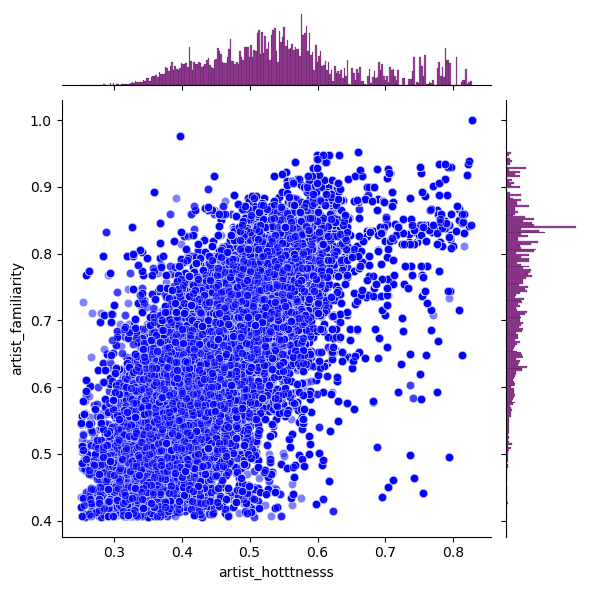

In [25]:
sns.jointplot(x = song_data['artist_hotttnesss'], y = song_data['artist_familiarity'], kind = 'scatter', alpha = 0.5, color = 'blue', marginal_kws = {'color': 'purple'})
plt.show()

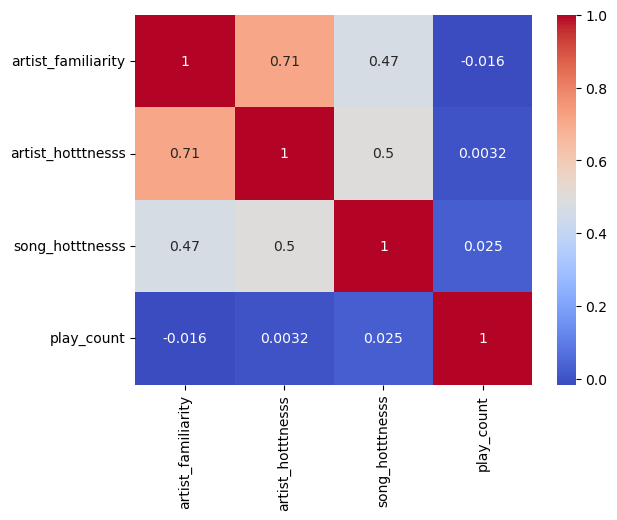

In [26]:
corr = song_data[['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'play_count']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [27]:
song_data['unencoded_sid'] = song_data['song_id']
song_data['unencoded_uid'] = song_data['user_id']

In [28]:
data_encoder = LabelEncoder()
song_data['song_id'] = data_encoder.fit_transform(song_data['song_id'])
song_data['user_id'] = data_encoder.fit_transform(song_data['user_id'])

In [29]:
song_dict = dict(zip(song_data['unencoded_sid'], song_data['song_id']))
user_dict = dict(zip(song_data['unencoded_uid'], song_data['user_id']))
song_data.drop(columns =['unencoded_sid'], inplace=True)
song_data.drop(columns =['unencoded_uid'], inplace=True)
song_data.head(8)

artist_familiarity  artist_hotttnesss      artist_name  \
0            0.832012           0.677482     Jack Johnson   
1            0.580555           0.482492    Billy Preston   
2            0.633119           0.417718    Paco De Lucia   
3            0.650281           0.451749     The Dead 60s   
4            0.576127           0.436974            Amset   
5            0.641037           0.412069    Jorge Drexler   
6            0.675339           0.499641       Josh Rouse   
7            0.806208           0.498077  Eric Hutchinson   

                                             release  song_hotttnesss  \
0                                 Thicker Than Water         0.649006   
1                                         To Die For         0.826375   
2                                Flamenco Para Niños         0.735295   
3  Nick & Norah's Infinite Playlist - Original Mo...         0.754628   
4                                              Amset         0.454193   
5                                    10 + Downloaded         0.265861   
6                              Under Cold Blue Stars         0.645846   
7                                   Sounds Like This         0.345802   

   song_id                               title   duration  user_id  play_count  
0     2078                            The Cove  112.63955    29941           1  
1     3051                Nothing from Nothing  153.59955    29941           1  
2     5461                     Entre Dos Aguas  358.24281    29941           2  
3     6263     Riot Radio (Soundtrack Version)  141.42649    29941           1  
4     7956                     Sin límites (I)  190.53669    29941           1  
5     8982            12 segundos de oscuridad  246.83057    29941           2  
6     9466  Ears To The Ground (Album Version)  171.17995    29941           1  
7     9823          Food Chain (Album Version)  221.20444    29941           1

In [30]:
scaler = MinMaxScaler()
track_metadata['duration'] = scaler.fit_transform(track_metadata[['duration']])

## SVD

In [31]:
reader = Reader(rating_scale=(1, 7))
songdata = Dataset.load_from_df(song_data[['user_id', 'song_id', 'play_count']], reader)

In [32]:
param_grid = {'n_epochs': [15, 20], 
              'lr_all': [0.007, 0.006], 
              'reg_all': [0.1, 0.2]}

grid_search = GridSearchCV(SVD,         
                           param_grid, 
                           measures=['rmse'], 
                           cv = 3,
                           n_jobs = -1, 
                           refit = True,
                           joblib_verbose = 1
                          )

grid_search.fit(songdata)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed:   37.4s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   53.2s finished


In [33]:
best_params = grid_search.best_params 
best_params

{'rmse': {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.1}}

In [34]:
from surprise.model_selection import train_test_split
train_set, test_set = train_test_split(songdata, test_size=0.1, random_state=42)
svd = SVD(n_factors= 2, n_epochs=20, lr_all= 0.007, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svd.fit(train_set)

In [35]:
svd_predictions = svd.test(test_set)
accuracy.rmse(svd_predictions)

RMSE: 1.1863


1.1862833919492393

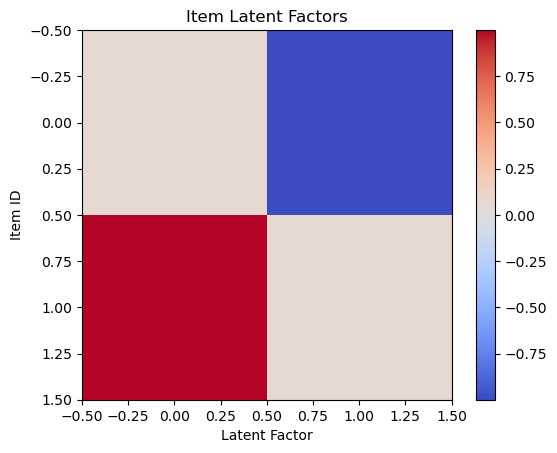

In [36]:
U, S, Vt = np.linalg.svd(svd.pu, full_matrices=False)
plt.imshow(Vt.T, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xlabel('Latent Factor')
plt.ylabel('Item ID')
plt.title('Item Latent Factors')
plt.show()

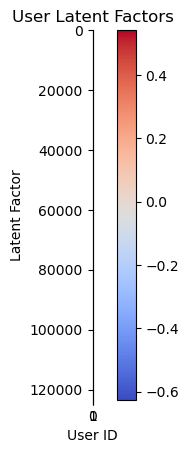

In [37]:
U, S, Vt = np.linalg.svd(svd.qi, full_matrices=False)
plt.imshow(U, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xlabel('User ID')
plt.ylabel('Latent Factor')
plt.title('User Latent Factors')
plt.show()

In [38]:
trainset = songdata.build_full_trainset()
svdc = SVD(n_factors= 2, n_epochs=20, lr_all= 0.007, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svdc.fit(trainset)
predictions = svdc.test(test_set)

## Processing text data and getting embeddings

In [39]:
song_data['title'] = song_data['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
song_data['title'] = song_data['title'].apply(lambda x: x.lower())

song_data['artist_name'] = song_data['artist_name'].apply(lambda x: str(x).lower())
song_data['artist_name'] = song_data['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

song_data['release'] = song_data['release'].apply(lambda x: str(x).lower())
song_data['release'] = song_data['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

In [40]:
svd_song_data = song_data
playcount_pred = []
for i in range(len(svd_song_data)):
  playcount_pred.append(svdc.predict(svd_song_data["user_id"][i], svd_song_data["song_id"][i]).est)
svd_song_data['playcount_pred'] = playcount_pred

In [41]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(svd_song_data, test_size=0.1, random_state=42)

In [42]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count']

train_input = train_data[inputs].copy()
train_target = train_data[target]

inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count']

test_input = test_data[inputs].copy()
test_target = test_data[target]

text_data = ['artist_name', 'title', 'release']
meta_text = train_data[text_data].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = test_data[test_text_data].copy()

train_input.shape, meta_text.shape, test_input.shape, test_meta_text.shape

((1285250, 10), (1285250, 3), (142806, 10), (142806, 3))

In [43]:
meta_text['text'] = meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in meta_text['text']]
emb_size = 30
model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

text_vector = []
for text in meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_ft.wv:
            vec += model_ft.wv[token]
    text_vector.append(vec)
    
text_vector = np.array(text_vector)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)
text_vector.shape, test_text_vector.shape

((1285250, 30), (142806, 30))

In [44]:
train_cols = train_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values 
train_with_meta = np.concatenate((text_vector, train_cols), axis=1)
train_with_meta.shape

test_cols = test_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values 
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)
test_with_meta.shape

song_col = ['song_id']
user_col = ['user_id']

song_input = train_input[song_col].copy()
user_input = train_input[user_col].copy()
song_input.shape, user_input.shape

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape,test_user_input.shape

max_song_id = max(train_input.song_id) 
max_user_id = max(train_input.user_id) 
song_input_dim = 1 
user_input_dim = 1 

meta_text_dim = train_with_meta.shape[1]

max_song_id, max_user_id, song_input_dim, user_input_dim, meta_text_dim

(127853, 41690, 1, 1, 35)

## Training neural network

In [45]:
input_song = Input(shape=(song_input_dim,), name='song_input') 
input_user = Input(shape=(user_input_dim,), name='user_input')
input_meta = Input(shape=(meta_text_dim,), name='metadata_input')

song_encoding = Embedding(max_song_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_song)
song_embeddings = Flatten()(song_encoding)

user_encoding = Embedding(max_user_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_user)
user_embeddings = Flatten()(user_encoding)

dense_layer = Dense(64, activation='relu')(input_meta)
metadata_embeddings = Dense(10, activation='relu', name='metadata_embeddings')(dense_layer)

concat = Concatenate()([song_embeddings, user_embeddings, metadata_embeddings])
hidden_layer = Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001))(concat)
hidden_layer = Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(hidden_layer)

lambda_layer = Lambda(lambda x: K.clip(x, 0.0, 7.0))
output_layer = Dense(1,activation=lambda_layer, kernel_initializer='lecun_uniform', name='output')(hidden_layer)

model = tf.keras.Model([input_song, input_user, input_meta], output_layer)

2023-04-30 23:11:34.408205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 23:11:34.413990: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [46]:
optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 song_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        1278540     ['song_input[0][0]']             
                                                                                              

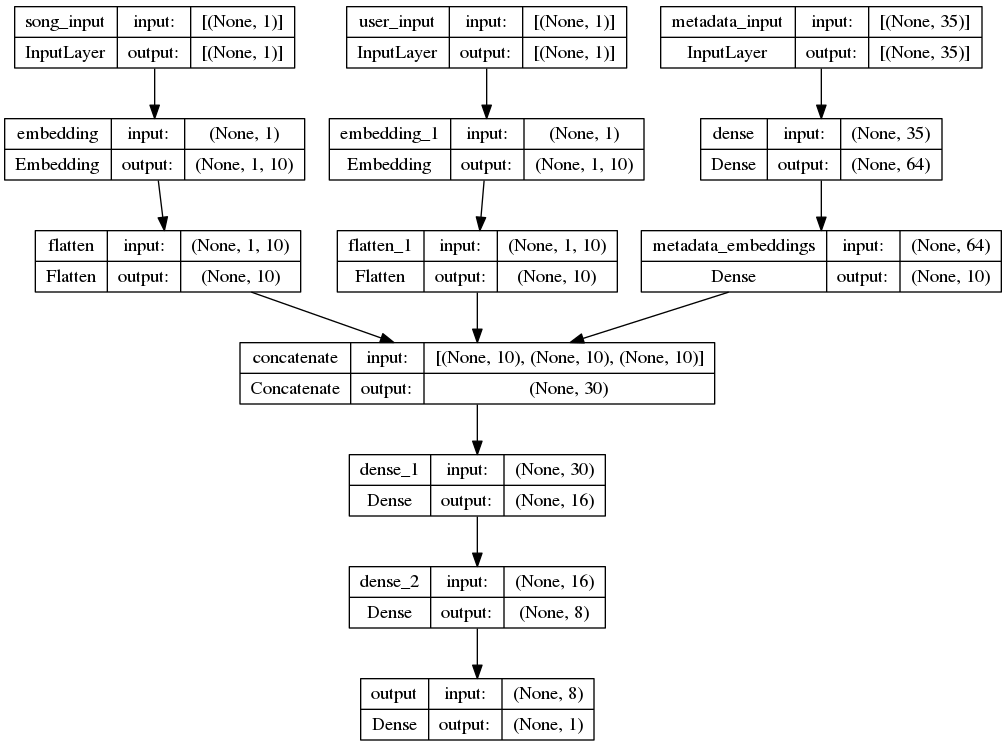

In [47]:
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

In [48]:
record_model_callback = LambdaCallback(  
    on_batch_end=lambda batch, logs: (
        loss_values.append(logs['loss']),
        acc_values.append(logs['accuracy']),
        rmse_values.append(np.sqrt(logs['root_mean_squared_error']))))

loss_values = []
rmse_values = []
acc_values = []

In [49]:
history = model.fit(
  [song_input, user_input, train_with_meta], train_target, 
  batch_size = 512, 
  epochs = 2, 
  verbose = 1,
  callbacks = [record_model_callback],
  validation_split=0.1
)

Epoch 1/2
2260/2260 [==============================] - 37s 16ms/step - loss: 1.5762 - accuracy: 0.6441 - root_mean_squared_error: 1.2493 - val_loss: 1.2591 - val_accuracy: 0.6456 - val_root_mean_squared_error: 1.1207
Epoch 2/2
2260/2260 [==============================] - 37s 17ms/step - loss: 1.2594 - accuracy: 0.6446 - root_mean_squared_error: 1.1211 - val_loss: 1.2419 - val_accuracy: 0.6456 - val_root_mean_squared_error: 1.1134


In [50]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy: ", train_acc)
print("Validation accuracy: ", train_acc)

Training accuracy:  [0.6441064476966858, 0.6446251273155212]
Validation accuracy:  [0.6441064476966858, 0.6446251273155212]


In [51]:
train_pred = model.predict([song_input, user_input, train_with_meta])
train_gt = train_target.values
train_rmse = np.sqrt(np.mean((train_pred - train_gt)**2))
print("Train RMSE: ", train_rmse)

40165/40165 [==============================] - 111s 3ms/step
Train RMSE:  1.1149424302851292


In [52]:
test_pred = model.predict([test_song_input, test_user_input, test_with_meta])
test_gt = test_target.values
test_rmse = np.sqrt(np.mean((test_pred - test_gt)**2))
test_rmse
print("Test RMSE: ", test_rmse)

4463/4463 [==============================] - 15s 3ms/step
Test RMSE:  1.1404417136386475


In [53]:
train_mae = mean_absolute_error(train_pred, train_gt)
test_mae = mean_absolute_error(test_pred, test_gt)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)

Train MAE:  0.7745904984063755
Test MAE:  0.8243493172769151


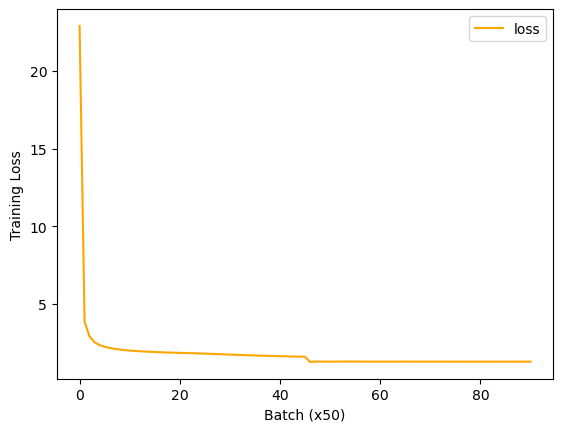

In [54]:
plt_loss_values = loss_values[::50]
plt.plot(np.arange(len(plt_loss_values)), plt_loss_values, label='loss', color = 'orange')
plt.xlabel('Batch (x50)')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

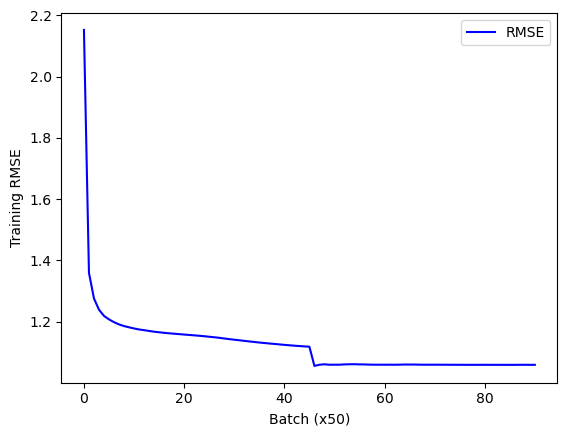

In [55]:
plt_rmse_values = rmse_values[::50]
plt.plot(np.arange(len(plt_rmse_values)), plt_rmse_values, label='RMSE', color='blue')
plt.xlabel('Batch (x50)')
plt.ylabel('Training RMSE')
plt.legend()
plt.show()

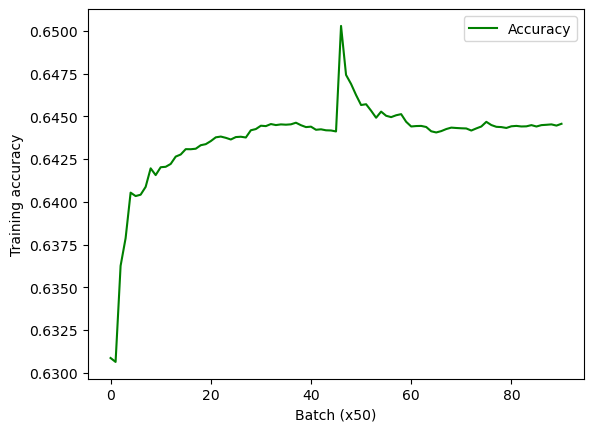

In [56]:
plt_acc_values = acc_values[::50]
plt.plot(np.arange(len(plt_acc_values)), plt_acc_values, label='Accuracy', color='green')
plt.xlabel('Batch (x50)')
plt.ylabel('Training accuracy')
plt.legend()
plt.show()

## Generating Recommendations

In [57]:
user_id = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
user_id = user_dict[user_id]
print("Encoded user ID: ")
user_id

Encoded user ID: 


29941

In [58]:
song_df = song_data.drop(columns=['user_id', 'play_count', 'playcount_pred'], axis=1)
song_df = song_df.sort_values('song_id', ascending=True)
song_df.drop_duplicates(inplace=True)
song_df.shape

(129001, 8)

In [59]:
song_df = song_df.reset_index(drop=True)
song_df.head(8)

artist_familiarity  artist_hotttnesss                         artist_name  \
0            0.634719           0.434737  i love you but ive chosen darkness   
1            0.771424           0.489474                    au revoir simone   
2            0.428437           0.480233            bohren  der club of gore   
3            0.694918           0.485572                        vic chesnutt   
4            0.504443           0.341171     mitch ryder  the detroit wheels   
5            0.556751           0.361588                    alejandro lerner   
6            0.734334           0.407817                         tim buckley   
7            0.673095           0.467843                           lou rawls   

                                      release  song_hotttnesss  song_id  \
0          i love you but ive chosen darkness         0.565447        0   
1                                     shadows         0.507669        1   
2                                     dolores         0.599117        2   
3                                  at the cut         0.627505        3   
4  rev up best of mitch ryder  detroit wheels         0.334707        4   
5                                     20 años         0.427447        5   
6                                    sefronia         0.591754        6   
7                 an axelrod anthology 68  70         0.604694        7   

                          title   duration  
0              the less you see  243.53914  
1                      grateful  190.87628  
2                     orgelblut  372.84526  
3  flirted with you all my life  281.49506  
4             sticks and stones  158.77179  
5          campeones de la vida  153.36444  
6      sally go round the roses  222.24934  
7            for what its worth  171.91138

In [60]:
user_df = song_data.sort_values('user_id', ascending=True)

In [61]:
songs_listened = user_df[user_df['user_id'] == user_id]['song_id'].tolist()
unique_songs = song_df['song_id'].unique().tolist()
unique_users = user_df['user_id'].unique().tolist()

In [62]:
to_recommend = song_df[~song_df['song_id'].isin(songs_listened)]
user_list = [user_id]*len(to_recommend)
to_recommend['user_id'] = user_list

/tmp/ipykernel_121033/3653136752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommend['user_id'] = user_list


In [63]:
svd_pred = []
for i, r in to_recommend.iterrows():
    u = r['user_id']
    s = r['song_id']
    preds = svd.predict(u, s).est
    svd_pred.append(preds)
to_recommend['playcount_pred'] = svd_pred

/tmp/ipykernel_121033/755124281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommend['playcount_pred'] = svd_pred


In [64]:
to_recommend.head(8)

artist_familiarity  artist_hotttnesss                         artist_name  \
0            0.634719           0.434737  i love you but ive chosen darkness   
1            0.771424           0.489474                    au revoir simone   
2            0.428437           0.480233            bohren  der club of gore   
3            0.694918           0.485572                        vic chesnutt   
4            0.504443           0.341171     mitch ryder  the detroit wheels   
5            0.556751           0.361588                    alejandro lerner   
6            0.734334           0.407817                         tim buckley   
7            0.673095           0.467843                           lou rawls   

                                      release  song_hotttnesss  song_id  \
0          i love you but ive chosen darkness         0.565447        0   
1                                     shadows         0.507669        1   
2                                     dolores         0.599117        2   
3                                  at the cut         0.627505        3   
4  rev up best of mitch ryder  detroit wheels         0.334707        4   
5                                     20 años         0.427447        5   
6                                    sefronia         0.591754        6   
7                 an axelrod anthology 68  70         0.604694        7   

                          title   duration  user_id  playcount_pred  
0              the less you see  243.53914    29941        1.334927  
1                      grateful  190.87628    29941        1.120461  
2                     orgelblut  372.84526    29941        1.426650  
3  flirted with you all my life  281.49506    29941        1.113328  
4             sticks and stones  158.77179    29941        1.196348  
5          campeones de la vida  153.36444    29941        1.069665  
6      sally go round the roses  222.24934    29941        1.373730  
7            for what its worth  171.91138    29941        1.875632

In [65]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
test_input = to_recommend[inputs].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = to_recommend[test_text_data].copy()

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)

test_cols = to_recommend[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)

song_col = ['song_id']
user_col = ['user_id']

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape, test_user_input.shape, test_with_meta.shape

((128920, 1), (128920, 1), (128920, 35))

In [66]:
user_playcount_pred = model.predict([test_song_input, test_user_input, test_with_meta])

4029/4029 [==============================] - 14s 3ms/step


In [67]:
user_playcount_pred.shape

(128920, 1)

In [68]:
to_recommend['final_prediction'] = user_playcount_pred

/tmp/ipykernel_121033/597565698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommend['final_prediction'] = user_playcount_pred


In [69]:
recommendations = to_recommend.sort_values('final_prediction', ascending=False)[:20]
recommendations.drop_duplicates(inplace=True)
recommendations.head(5)

artist_familiarity  artist_hotttnesss         artist_name  \
80045            0.694813           0.467062        morbid angel   
28854            0.774802           0.459186  insane clown posse   
16196            0.519970           0.419777         ma numminen   
5108             0.793275           0.499761         yo la tengo   
8397             0.573102           0.399247        carnal forge   

                                                 release  song_hotttnesss  \
80045                                 entangled in chaos         0.319566   
28854                        the amazing jeckel brothers         0.493730   
16196  itsy bitsy ja muita taidenautintoja  itsy bits...         0.260338   
5108   prisoners of love a smattering of scintillatin...         0.667018   
8397                                  arent you dead yet         0.517376   

       song_id                  title   duration  user_id  playcount_pred  \
80045    79286  chapel of ghouls live  226.66404    29941        3.047166   
28854    28596          fck the world  223.76444    29941        3.011604   
16196    16044            tulenliekki  166.55628    29941        3.144654   
5108      5074      the story of jazz  215.24853    29941        1.718554   
8397      8313     decades of despair  182.33424    29941        2.875743   

       final_prediction  
80045          3.394577  
28854          3.344086  
16196          3.337167  
5108           3.296411  
8397           3.262928

In [70]:
print("The top 20 recommendations for the user are: \n\n")
for song_recommendation in recommendations[['title', 'release', 'artist_name']].values:
    print(song_recommendation[0].upper(), "from the album", song_recommendation[1].upper(), "by", song_recommendation[2].upper())

The top 20 recommendations for the user are: 


CHAPEL OF GHOULS LIVE from the album ENTANGLED IN CHAOS by MORBID ANGEL
FCK THE WORLD from the album THE AMAZING JECKEL BROTHERS by INSANE CLOWN POSSE
TULENLIEKKI from the album ITSY BITSY JA MUITA TAIDENAUTINTOJA  ITSY BITSY OCH ANDRA KONSTUPPLEVELSER by MA NUMMINEN
THE STORY OF JAZZ from the album PRISONERS OF LOVE A SMATTERING OF SCINTILLATING  SENESCENT SONGS 19852003 PLUS A SMATTERING OF OUT by YO LA TENGO
DECADES OF DESPAIR from the album ARENT YOU DEAD YET by CARNAL FORGE
LOST CONTROL from the album PLAYLIST THE VERY BEST OF A FLOCK OF SEAGULLS by A FLOCK OF SEAGULLS
LULLABYE FOR WAYNE from the album WEEZER RARITIES EDITION by WEEZER
LULLABYE FOR WAYNE from the album WEEZER RARITIES EDITION by WEEZER
LULLABYE FOR WAYNE from the album WEEZER by WEEZER
LULLABYE FOR WAYNE from the album WEEZER by WEEZER
A WOMAN A MAN WALKED BY  THE CROW KNOWS WHERE ALL THE LITTLE CHILDREN GO from the album A WOMAN A MAN WALKED BY by PJ HARVEY  JOHN PA

## Training based on likeness

In [71]:
song_norm = song_data[['user_id','play_count']].groupby('user_id').sum().reset_index()
song_norm.columns = ['user_id','total_play_counts']
song_norm_df=pd.merge(song_data, song_norm, on='user_id', how= 'left')
song_norm_df['play_count_norm'] = song_norm_df['play_count']/song_norm_df['total_play_counts']

In [72]:
reader = Reader(rating_scale=(0, 1))
songdata_norm = Dataset.load_from_df(song_norm_df[['user_id', 'song_id', 'play_count_norm']], reader)

In [73]:
param_grid = {'n_factors': [2, 3],      
              'n_epochs': [15, 20], 
              'lr_all': [0.007, 0.008], 
              'reg_all': [0.1, 0.2]}

grid_search = GridSearchCV(SVD,         
                           param_grid, 
                           measures=['rmse'], 
                           cv = 3,
                           n_jobs = -1, 
                           refit = True,
                           joblib_verbose = 1
                          )

grid_search.fit(songdata_norm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  48 | elapsed:   58.0s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


In [74]:
best_params = grid_search.best_params 
best_params

{'rmse': {'n_factors': 2, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.1}}

In [75]:
from surprise.model_selection import train_test_split
train_set, test_set = train_test_split(songdata_norm, test_size=0.1, random_state=42)
svd = SVD(n_factors= 2, n_epochs=20, lr_all= 0.008, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svd.fit(train_set)

In [76]:
svd_predictions = svd.test(test_set)
accuracy.rmse(svd_predictions)

RMSE: 0.0318


0.03181169245608028

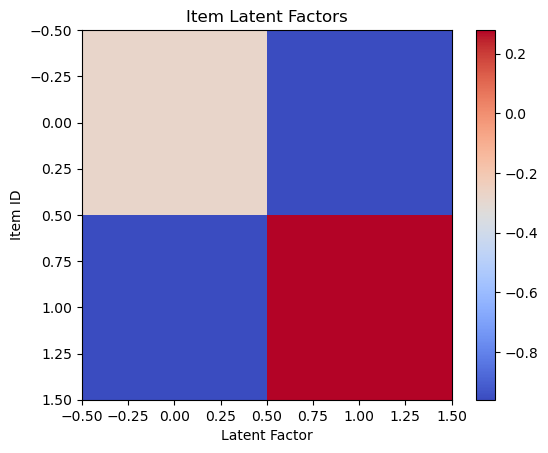

In [77]:
U, S, Vt = np.linalg.svd(svd.pu, full_matrices=False)
plt.imshow(Vt.T, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xlabel('Latent Factor')
plt.ylabel('Item ID')
plt.title('Item Latent Factors')
plt.show()

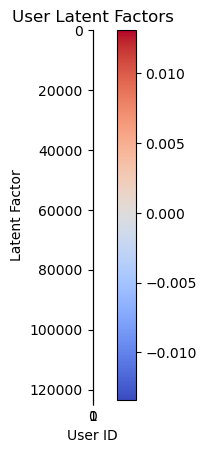

In [78]:
U, S, Vt = np.linalg.svd(svd.qi, full_matrices=False)
plt.imshow(U, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xlabel('User ID')
plt.ylabel('Latent Factor')
plt.title('User Latent Factors')
plt.show()

In [79]:
trainset = songdata_norm.build_full_trainset()
svdc = SVD(n_factors= 2, n_epochs=20, lr_all= 0.008, reg_all= 0.1, init_mean= 0, init_std_dev= 0.001)
svdc.fit(trainset)
predictions = svdc.test(test_set)

In [80]:
song_norm_df['title'] = song_norm_df['title'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
song_norm_df['title'] = song_norm_df['title'].apply(lambda x: x.lower())

song_norm_df['artist_name'] = song_norm_df['artist_name'].apply(lambda x: str(x).lower())
song_norm_df['artist_name'] = song_norm_df['artist_name'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

song_norm_df['release'] = song_norm_df['release'].apply(lambda x: str(x).lower())
song_norm_df['release'] = song_norm_df['release'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

In [81]:
svd_song_data = song_norm_df
playcount_pred = []
for i in range(len(svd_song_data)):
  playcount_pred.append(svdc.predict(svd_song_data["user_id"][i], svd_song_data["song_id"][i]).est)
svd_song_data['playcount_pred'] = playcount_pred

In [82]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(svd_song_data, test_size=0.1, random_state=42)

In [83]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count_norm']

train_input = train_data[inputs].copy()
train_target = train_data[target]

inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
target = ['play_count_norm']

test_input = test_data[inputs].copy()
test_target = test_data[target]

text_data = ['artist_name', 'title', 'release']
meta_text = train_data[text_data].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = test_data[test_text_data].copy()

train_input.shape, meta_text.shape, test_input.shape, test_meta_text.shape

((1285250, 10), (1285250, 3), (142806, 10), (142806, 3))

In [84]:
meta_text['text'] = meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in meta_text['text']]
emb_size = 30
model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

text_vector = []
for text in meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in model_ft.wv:
            vec += model_ft.wv[token]
    text_vector.append(vec)
    
text_vector = np.array(text_vector)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)
text_vector.shape, test_text_vector.shape

((1285250, 30), (142806, 30))

In [85]:
train_cols = train_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values 
train_with_meta = np.concatenate((text_vector, train_cols), axis=1)
train_with_meta.shape

test_cols = test_input[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values 
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)
test_with_meta.shape

song_col = ['song_id']
user_col = ['user_id']

song_input = train_input[song_col].copy()
user_input = train_input[user_col].copy()
song_input.shape, user_input.shape

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()
test_song_input.shape,test_user_input.shape

max_song_id = max(train_input.song_id) 
max_user_id = max(train_input.user_id) 
song_input_dim = 1 
user_input_dim = 1 

meta_text_dim = train_with_meta.shape[1]

max_song_id, max_user_id, song_input_dim, user_input_dim, meta_text_dim

(127853, 41690, 1, 1, 35)

## Training neural network with norm play counts 

In [86]:
input_song = Input(shape=(song_input_dim,), name='song_input') 
input_user = Input(shape=(user_input_dim,), name='user_input')
input_meta = Input(shape=(meta_text_dim,), name='metadata_input')

song_encoding = Embedding(max_song_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_song)
song_embeddings = Flatten()(song_encoding)

user_encoding = Embedding(max_user_id+1 ,10, embeddings_regularizer=regularizers.L2(0.001))(input_user)
user_embeddings = Flatten()(user_encoding)

dense_layer = Dense(64, activation='relu')(input_meta)
metadata_embeddings = Dense(10, activation='relu', name='metadata_embeddings')(dense_layer)

concat = Concatenate()([song_embeddings, user_embeddings, metadata_embeddings])
hidden_layer = Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.001))(concat)
hidden_layer = Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(hidden_layer)

lambda_layer = Lambda(lambda x: K.clip(x, 0.0, 7.0))
output_layer = Dense(1,activation=lambda_layer, kernel_initializer='lecun_uniform', name='output')(hidden_layer)

model = tf.keras.Model([input_song, input_user, input_meta], output_layer)

In [87]:
optimizer = Adam(lr=0.001, epsilon = 1e-6, amsgrad=True)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 song_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 metadata_input (InputLayer)    [(None, 35)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 10)        1278540     ['song_input[0][0]']             
                                                                                            

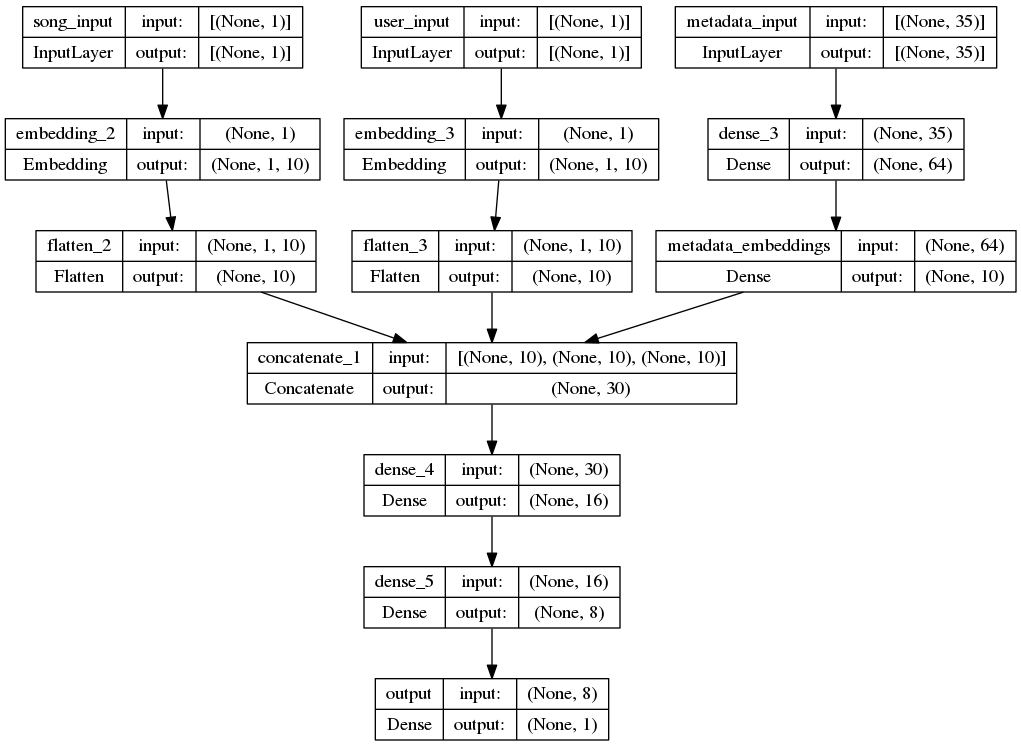

In [88]:
plot_model(model, to_file='model_norm.png', show_shapes = True, show_layer_names = True)

In [89]:
record_model_callback = LambdaCallback(  
    on_batch_end=lambda batch, logs: (
        loss_values.append(logs['loss']),
        rmse_values.append(np.sqrt(logs['root_mean_squared_error']))))

loss_values = []
rmse_values = []

In [90]:
history = model.fit(
  [song_input, user_input, train_with_meta], train_target, 
  batch_size = 512, 
  epochs = 2, 
  verbose = 1,
  callbacks = [record_model_callback],
  validation_split=0.1
)

Epoch 1/2
2260/2260 [==============================] - 39s 17ms/step - loss: 0.0140 - root_mean_squared_error: 0.0521 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0516
Epoch 2/2
2260/2260 [==============================] - 38s 17ms/step - loss: 0.0029 - root_mean_squared_error: 0.0517 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0516


In [91]:
train_pred = model.predict([song_input, user_input, train_with_meta])
train_gt = train_target.values
train_rmse = np.sqrt(np.mean((train_pred - train_gt)**2))
print("Train RMSE: ", train_rmse)

test_pred = model.predict([test_song_input, test_user_input, test_with_meta])
test_gt = test_target.values
test_rmse = np.sqrt(np.mean((test_pred - test_gt)**2))
test_rmse
print("Test RMSE: ", test_rmse)

train_mae = mean_absolute_error(train_pred, train_gt)
test_mae = mean_absolute_error(test_pred, test_gt)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)

40165/40165 [==============================] - 144s 4ms/step
Train RMSE:  0.051685069275667087
4463/4463 [==============================] - 12s 3ms/step
Test RMSE:  0.05200388413879302
Train MAE:  0.029191412795043264
Test MAE:  0.029219617559280472


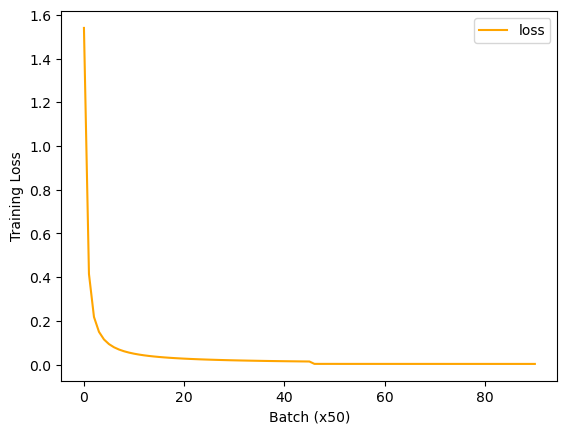

In [92]:
plt_loss_values = loss_values[::50]
plt.plot(np.arange(len(plt_loss_values)), plt_loss_values, label='loss', color = 'orange')
plt.xlabel('Batch (x50)')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

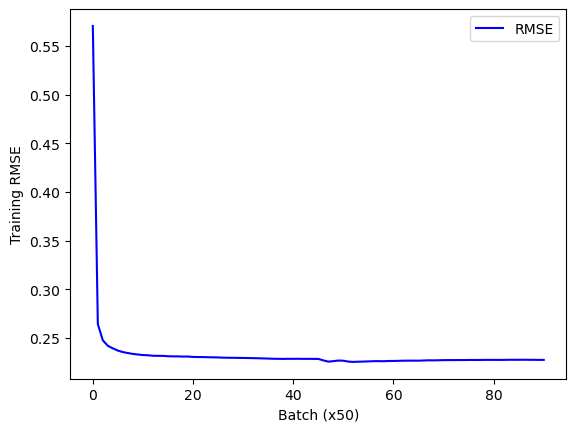

In [93]:
plt_rmse_values = rmse_values[::50]
plt.plot(np.arange(len(plt_rmse_values)), plt_rmse_values, label='RMSE', color='blue')
plt.xlabel('Batch (x50)')
plt.ylabel('Training RMSE')
plt.legend()
plt.show()

In [94]:
user_id = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
user_id = user_dict[user_id]
print("Encoded user ID: ")
user_id

Encoded user ID: 


29941

In [95]:
song_df = song_norm_df.drop(columns=['user_id', 'play_count_norm', 'playcount_pred'], axis=1)
song_df = song_df.sort_values('song_id', ascending=True)
song_df.drop_duplicates(inplace=True)

In [96]:
song_df = song_df.reset_index(drop=True)
song_df.head(8)

artist_familiarity  artist_hotttnesss                         artist_name  \
0            0.634719           0.434737  i love you but ive chosen darkness   
1            0.634719           0.434737  i love you but ive chosen darkness   
2            0.771424           0.489474                    au revoir simone   
3            0.771424           0.489474                    au revoir simone   
4            0.771424           0.489474                    au revoir simone   
5            0.428437           0.480233            bohren  der club of gore   
6            0.428437           0.480233            bohren  der club of gore   
7            0.428437           0.480233            bohren  der club of gore   

                              release  song_hotttnesss  song_id  \
0  i love you but ive chosen darkness         0.565447        0   
1  i love you but ive chosen darkness         0.565447        0   
2                             shadows         0.507669        1   
3                             shadows         0.507669        1   
4                             shadows         0.507669        1   
5                             dolores         0.599117        2   
6                             dolores         0.599117        2   
7                             dolores         0.599117        2   

              title   duration  play_count  total_play_counts  
0  the less you see  243.53914           2                122  
1  the less you see  243.53914           1                734  
2          grateful  190.87628           1                389  
3          grateful  190.87628           1                163  
4          grateful  190.87628           2                266  
5         orgelblut  372.84526           2                 72  
6         orgelblut  372.84526           1                128  
7         orgelblut  372.84526           1                311

In [97]:
user_df = song_norm_df.sort_values('user_id', ascending=True)
songs_listened = user_df[user_df['user_id'] == user_id]['song_id'].tolist()
unique_songs = song_df['song_id'].unique().tolist()
unique_users = user_df['user_id'].unique().tolist()

In [98]:
to_recommendn = song_df[~song_df['song_id'].isin(songs_listened)]
user_list = [user_id]*len(to_recommendn)
to_recommendn['user_id'] = user_list

/tmp/ipykernel_121033/2497640423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommendn['user_id'] = user_list


In [99]:
svd_pred = []
for i, r in to_recommendn.iterrows():
    u = r['user_id']
    s = r['song_id']
    preds = svd.predict(u, s).est
    svd_pred.append(preds)
to_recommendn['playcount_pred'] = svd_pred

/tmp/ipykernel_121033/505953055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommendn['playcount_pred'] = svd_pred


In [100]:
inputs = ['user_id', 'song_id', 'artist_name', 'title', 'release', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']
test_input = to_recommendn[inputs].copy()

test_text_data = ['artist_name', 'title', 'release']
test_meta_text = to_recommendn[test_text_data].copy()

test_meta_text['text'] = test_meta_text.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
corpus = [text.split() for text in test_meta_text['text']]
emb_size = 30
test_model_ft = FastText(sentences=corpus, vector_size=emb_size, window=5, min_count=1, workers=4, sg=0)

test_text_vector = []
for text in test_meta_text['text']:
    vec = np.zeros(emb_size)
    tokens = text.split()
    for token in tokens:
        if token in test_model_ft.wv:
            vec += test_model_ft.wv[token]
    test_text_vector.append(vec)
    
test_text_vector = np.array(test_text_vector)

test_cols = to_recommendn[['duration', 'artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'playcount_pred']].values
test_with_meta = np.concatenate((test_text_vector, test_cols), axis=1)

song_col = ['song_id']
user_col = ['user_id']

test_song_input = test_input[song_col].copy()
test_user_input = test_input[user_col].copy()

In [101]:
to_recommendn.head(8)

artist_familiarity  artist_hotttnesss                         artist_name  \
0            0.634719           0.434737  i love you but ive chosen darkness   
1            0.634719           0.434737  i love you but ive chosen darkness   
2            0.771424           0.489474                    au revoir simone   
3            0.771424           0.489474                    au revoir simone   
4            0.771424           0.489474                    au revoir simone   
5            0.428437           0.480233            bohren  der club of gore   
6            0.428437           0.480233            bohren  der club of gore   
7            0.428437           0.480233            bohren  der club of gore   

                              release  song_hotttnesss  song_id  \
0  i love you but ive chosen darkness         0.565447        0   
1  i love you but ive chosen darkness         0.565447        0   
2                             shadows         0.507669        1   
3                             shadows         0.507669        1   
4                             shadows         0.507669        1   
5                             dolores         0.599117        2   
6                             dolores         0.599117        2   
7                             dolores         0.599117        2   

              title   duration  play_count  total_play_counts  user_id  \
0  the less you see  243.53914           2                122    29941   
1  the less you see  243.53914           1                734    29941   
2          grateful  190.87628           1                389    29941   
3          grateful  190.87628           1                163    29941   
4          grateful  190.87628           2                266    29941   
5         orgelblut  372.84526           2                 72    29941   
6         orgelblut  372.84526           1                128    29941   
7         orgelblut  372.84526           1                311    29941   

   playcount_pred  
0        0.010624  
1        0.010624  
2        0.009751  
3        0.009751  
4        0.009751  
5        0.020155  
6        0.020155  
7        0.020155

In [111]:
user_playcount_pred = model.predict([test_song_input, test_user_input, test_with_meta])
to_recommendn['nn_pred'] = user_playcount_pred
to_recommendn['final_prediction'] = to_recommendn['playcount_pred']/2 + to_recommendn['nn_pred']/2
recommendations = to_recommendn.sort_values('final_prediction', ascending=False)[:20]

40441/40441 [==============================] - 142s 4ms/step


/tmp/ipykernel_121033/2531141852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommendn['nn_pred'] = user_playcount_pred
/tmp/ipykernel_121033/2531141852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_recommendn['final_prediction'] = to_recommendn['playcount_pred']/2 + to_recommendn['nn_pred']/2


In [112]:
print("The top recommendations for the user are: \n\n")
recommendations = recommendations[['title', 'release', 'artist_name']]
recommendations = recommendations.drop_duplicates()
for song_recommendation in recommendations[['title', 'release', 'artist_name']].values:
    print(song_recommendation[0].upper(), "from the album", song_recommendation[1].upper(), "by", song_recommendation[2].upper())

The top recommendations for the user are: 


KING OF NEW ORLEANS LP VERSION from the album RHINO HIFIVE BETTER THAN EZRA by BETTER THAN EZRA
TOO MUCH OF NOTHING LP VERSION from the album RHINO HIFIVE PETER_ PAUL  MARY by PETER_ PAUL AND MARY
HOLD ON TO ME REMASTERED LP VERSION from the album THE VERY BEST OF JOHN MICHAEL MONTGOMERY by JOHN MICHAEL MONTGOMERY
IVE GOT A FLAIR LP VERSION from the album FOUNTAINS OF WAYNE by FOUNTAINS OF WAYNE
